In [1]:
"""Scripts for analyzing of phantom outputs.

This script analyze the dump files about the opacity based on density and temperature.

"""

'Scripts for analyzing of phantom outputs.\n\nThis script analyze the dump files about the opacity based on density and temperature.\n\n'

# Main

## Imports & Settings

In [2]:
import numpy as np
from astropy import units
import matplotlib.pyplot as plt
import matplotlib as mpl
from os import path
try: from moviepy import editor
except RuntimeError: import os; os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"
from moviepy.editor import ImageSequenceClip

In [3]:
# import my modules listed in ./main/

import clmuphantomlib as mupl
#from main.clmuphantomlib.readwrite import json_load
from clmuphantomlib.log import is_verbose, say
from clmuphantomlib.settings   import DEFAULT_SETTINGS as settings
from clmuphantomlib.units_util import get_val_in_unit #set_as_quantity, get_units_field_name, get_units_cgs
from clmuphantomlib.eos.mesa   import EoS_MESA_opacity
from multiprocessing import cpu_count, Pool #Process, Queue
NPROCESSES = 1 if cpu_count() is None else max(cpu_count(), 1)

In [4]:
# settings
#
#   imported from script_input.py file


from script_kappaProfile__input import verbose, fps, unitsOut, output_dir, JOB_PROFILES_DICT
from _sharedFuncs import mpdf_read

unitsOutTxt = {  key  : unitsOut[key].to_string('latex_inline') for key in unitsOut.keys() }


plt.rcParams.update({'font.size': 20})
if __name__ == '__main__' and is_verbose(verbose, 'note'):
    # remember to check if name is '__main__' if you wanna say anything
    #    so when you do multiprocessing the program doesn't freak out
    say('note', "script", verbose, f"Will use {NPROCESSES} processes for parallelization")


*   Note   :    script:
	Will use 8 processes for parallelization


In [5]:
# functions

# plot_kappaProfile(job_name, file_index, eos_opacity, xlims, ylim, verbose)
def plot_kappaProfile_both(
    job_nickname: str,
    job_name: str, file_index: int, eos_opacity: EoS_MESA_opacity,
    xlims: dict,
    ylim: tuple,
    output_dir: str,
    plot_data_step: int = 1,
    save_pdf = False,
    verbose: int = 3,
) -> str:
    """Plot kappa Profile of a dump.

    Warning: assume a hard-coded constant kappa_gas as 2e-4 cm2/g

    Returns outfilename
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
    fig.subplots_adjust(wspace=0.0)
    mpdf = mupl.MyPhantomDataFrames().read(job_name, file_index, verbose=verbose) # reset_xyz_by_CoM=True, 
    #jobfilename = mupl.get_filename_phantom_dumps(job_name, file_index)
    jobfilename = mpdf.get_filename()
    # get temperature column label (one of the elem in the set below)
    temp_key = {'T', 'temperature', 'Tdust'}.intersection(mpdf.data['gas'].keys()).pop()
    mpdf.data['gas']['T'    ] = mpdf.data['gas'][temp_key]
    mpdf.data['gas']['kappa'] = get_val_in_unit(mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])

    y_dust = mpdf.get_val('kappa').to(unitsOut['opacity'])
    y_mesa = eos_opacity.get_kappa(mpdf.get_val('rho'), mpdf.get_val('T'), do_extrap=False).to(unitsOut['opacity'])
    y_extrap_indexes = np.where(~np.isfinite(y_mesa))[0]
    y_mesa_extrap = eos_opacity.get_kappa(
        mpdf.get_val('rho')[y_extrap_indexes], mpdf.get_val('T')[y_extrap_indexes], do_extrap=True).cgs

    # setting the switch between mesa opacity from phantom and nucleation opacity from luis
    # mesa opacity table from phantom uses Ferguson-2005-1 for opacity calc at low T (T < 1e4 K),
    #    which includes opacity from grains forming.
    #    We don't want that becaues we have our own carbon dust nucleation opacity.
    #    according to Ferguson-2005-1 fig9, grains dominates at T < 1450K (for logR=-3, X=0.7, Z=0.02)
    T_0, T_delta = 1450 * units.K, 50 * units.K
    x = mpdf.get_val('T').to(unitsOut['temp'], equivalencies=units.equivalencies.temperature())
    kappa_gas = (2e-4*(units.cm**2/units.g)).to(unitsOut['opacity'])
    y_comb = np.where(x < T_0, y_dust, y_dust - kappa_gas + y_mesa)

    # alias
    pds = plot_data_step
    
    # kappa vs temp
    ax = axes[0]
    x = mpdf.get_val('T').to(unitsOut['temp'], equivalencies=units.equivalencies.temperature())
    x_extrap = x[y_extrap_indexes]
    ax.loglog(x[::pds], y_dust[::pds], '.', label='Nucleation')
    ax.loglog(x[::pds], y_mesa[::pds], '.', label='MESA')
    ax.loglog(x_extrap[::pds], y_mesa_extrap[::pds], '.', label='MESA extrap')
    ax.loglog(x[::pds], y_comb[::pds], '.', label='Blended')
    ax.set_xlim(xlims['T'])
    ax.set_ylim(ylim)
    ax.set_xlabel(f"$T$ / {x.unit.to_string('latex_inline')}")
    ax.set_ylabel(f"$\\kappa$ / {y_dust.unit.to_string('latex_inline')}")
    ax.text(
        0.02, 0.98,
        f"Time = {mpdf.get_time(unitsOut['time']):.1f}",
        color = "black", ha = 'left', va = 'top',
        transform=ax.transAxes,
    )

    # kappa vs rho
    ax = axes[1]
    x = mpdf.get_val('rho').to(unitsOut['density'])
    x_extrap = x[y_extrap_indexes]
    ax.loglog(x[::pds], y_dust[::pds], '.', label='Nucleation')
    ax.loglog(x[::pds], y_mesa[::pds], '.', label='MESA')
    ax.loglog(x_extrap[::pds], y_mesa_extrap[::pds], '.', label='MESA extrap')
    ax.loglog(x[::pds], y_comb[::pds], '.', label='Blended')
    ax.set_xlim(xlims['rho'])
    ax.set_ylim(ylim)
    ax.set_xlabel(f"$\\rho$ / {x.unit.to_string('latex_inline')}")
    ax.legend(loc='lower right')

    outfilename_noext = f"{output_dir}{job_nickname}_{file_index:05d}__kappaProfile"
    if save_pdf:
        outfilename = f"{outfilename_noext}.pdf"
        fig.savefig(outfilename)
        if is_verbose(verbose, 'note'):
            say('note', None, verbose, f"Saved figure to {outfilename}.")
    
    fig.suptitle(
        f"Opacity of every {pds}-th particles in the dump (different calculation method)\n"
        #f"resolution = {mpdf.params['nparttot']:.2e}\n"
        f"{job_profile['plot_title_suffix']}"
    )

    outfilename = f"{outfilename_noext}.png"
    fig.savefig(outfilename)
    if is_verbose(verbose, 'note'):
        say('note', None, verbose, f"Saved figure to {outfilename}.")
    plt.close(fig)
    del mpdf

    return outfilename

In [6]:
    file_index = 4800
    T_cond_oxy = 1450 * units.K
    kappa_gas_const = (2e-4*(units.cm**2/units.g)).to(unitsOut['opacity'])
    
    mpdf = mpdf_read(job_name, file_index, eos_opacity, kappa_gas=kappa_gas_const, T_cond_oxy=T_cond_oxy, verbose=verbose)
    x = mpdf.get_val('T').to(unitsOut['temp'], equivalencies=units.equivalencies.temperature())
    y_comb = mpdf.get_val('kappa').to(unitsOut['opacity'])
    y_dust = mpdf.get_val('kappaDust').to(unitsOut['opacity'])
    y_mesa = eos_opacity.get_kappa(mpdf.get_val('rho'), mpdf.get_val('T'), do_extrap=False).to(unitsOut['opacity'])
    y_extrap_indexes = np.where(~np.isfinite(y_mesa))[0]
    y_mesa_extrap = eos_opacity.get_kappa(
        mpdf.get_val('rho')[y_extrap_indexes], mpdf.get_val('T')[y_extrap_indexes], do_extrap=True).cgs


NameError: name 'job_name' is not defined

In [ ]:
np.count_nonzero(x < T_cond_oxy)

In [ ]:
help(ax.hlines)

In [ ]:
# functions

# plot_kappaProfile(job_name, file_index, eos_opacity, xlims, ylim, verbose)
def plot_kappaProfile_part(
    fig: mpl.figure.Figure,
    ax : mpl.axes._axes.Axes,
    job_name: str,
    file_index: int,
    eos_opacity: EoS_MESA_opacity,
    xlims: dict,
    ylim: tuple,
    is_top_ax    : bool = True,
    is_bottom_ax : bool = True,
    do_title     : bool = False,
    plot_data_step: int = 1,
    alpha_part: float = 0.5,    # 0.0625
    alpha_comb: float = 1.0,    # 0.0625
    verbose: int = 3,
) -> tuple[mpl.figure.Figure, mpl.axes._axes.Axes]:
    """Plot kappa Profile of a dump.

    Warning: assume a hard-coded constant kappa_gas as 2e-4 cm2/g

    Returns outfilename
    """
    
    T_cond_oxy = 1450 * units.K
    kappa_gas_const = (2e-4*(units.cm**2/units.g)).to(unitsOut['opacity'])
    
    mpdf = mpdf_read(job_name, file_index, eos_opacity, kappa_gas=kappa_gas_const, T_cond_oxy=T_cond_oxy, verbose=verbose)
    x = mpdf.get_val('T').to(unitsOut['temp'], equivalencies=units.equivalencies.temperature())
    y_comb = mpdf.get_val('kappa').to(unitsOut['opacity'])
    y_dust = mpdf.get_val('kappaDust').to(unitsOut['opacity'])
    y_mesa = eos_opacity.get_kappa(mpdf.get_val('rho'), mpdf.get_val('T'), do_extrap=False).to(unitsOut['opacity'])
    y_extrap_indexes = np.where(~np.isfinite(y_mesa))[0]
    y_mesa_extrap = eos_opacity.get_kappa(
        mpdf.get_val('rho')[y_extrap_indexes], mpdf.get_val('T')[y_extrap_indexes], do_extrap=True).cgs

    # alias
    pds = plot_data_step
    ind_g = x >= T_cond_oxy    # indices for in the gas-opacity region
    
    
    # kappa vs temp
    x = mpdf.get_val('T').to(unitsOut['temp'], equivalencies=units.equivalencies.temperature())
    x_extrap = x[y_extrap_indexes]
    ax.loglog(x[        ::pds], y_dust[        ::pds], '.',  color='C1', label='$\\kappa_\\mathrm{dust}$', alpha=alpha_part)
    # ax.loglog(x[~ind_g][::pds], y_comb[~ind_g][::pds], '.',  color='C1', label='Blended: Nucleation-dominated', alpha=alpha_comb)
    ax.loglog(x[ ind_g][::pds], y_mesa[ ind_g][::pds], '.',  color='C0', label='$\\kappa_\\mathrm{gas}$', alpha=alpha_part)
    # ax.loglog(x_extrap[::pds], y_mesa_extrap[::pds], '.', label='MESA extrap', alpha=alpha_part)
    # ax.loglog(x[::pds], y_comb[::pds], '.', label='Blended', alpha=alpha_comb)
    ax.set_xlim(xlims['T'])
    ax.set_ylim(ylim)
    ax.set_ylabel(f"$\\kappa$ / {y_dust.unit.to_string('latex_inline')}")
    ax.hlines(kappa_gas_const.value, xmin=T_cond_oxy.value, xmax=ax.get_xlim()[1], color='C0', linestyle='dashed')
    ax.axvline(T_cond_oxy.value, color='C2', linestyle='dashed')
    if is_top_ax:
        ax.text(
            T_cond_oxy.value, ylim[1]/((ylim[1]/ylim[0])**0.02),
            f"$T_\\mathrm{{cutoff}} = {T_cond_oxy.value:.0f}$ {T_cond_oxy.unit.to_string('latex_inline')}",
            ha='left', va='top')
    if is_bottom_ax:
        ax.text(
            ax.get_xlim()[1], kappa_gas_const.value,
            f"$\\kappa_\\mathrm{{gas}} = {kappa_gas_const.value/1e-4:.0f}" +
            f"\\times 10^{{-4}}$ {kappa_gas_const.unit.to_string('latex_inline')}",
            ha='right', va='bottom')
        ax.set_xlabel(f"$T$ / {x.unit.to_string('latex_inline')}")
        ax.legend(loc='lower left')
    ax.text(
        0.02, 0.98,
        f"Time = {mpdf.get_time(unitsOut['time']):.1f}",
        color = "black", ha = 'left', va = 'top',
        transform=ax.transAxes,
    )
    if is_top_ax:
        if do_title:
            fig.suptitle(
                f"Opacity of every particles in the dump (different calculation method)\n"
                #f"resolution = {mpdf.params['nparttot']:.2e}\n"
                f"{job_profile['plot_title_suffix']}"
            )



    del mpdf

    return fig, ax

In [ ]:
do_debug = True
if __name__ == '__main__' and do_debug:
    ylim = (5e-6, 5e4)
    xlims= {
        'T'  : (2e6,   5.),
        'rho': (1e-3, 2e-20),
    }
    job_nickname = '2md'
    file_indexes  = [1200, 4800, 17600]#[400, 2000, 4800, 6400, 17600]
    
    job_profile = JOB_PROFILES_DICT[job_nickname]
    job_name    = job_profile['job_name']
    params      = job_profile['params']
    eos_opacity = EoS_MESA_opacity(params, settings)
    
    fig, axes = plt.subplots(len(file_indexes), 1, figsize=(12, 4*len(file_indexes)), squeeze=False, sharex=True)
    fig.subplots_adjust(hspace=0.0)
    axes = axes[..., 0]
    for i in range(len(file_indexes)):
        file_index, ax = file_indexes[i], axes[i]

        fig, ax = plot_kappaProfile_part(
            fig, ax, job_name, file_index, eos_opacity, xlims, ylim,
            is_top_ax=(i==0), is_bottom_ax=(i==len(file_indexes)-1), do_title=False, verbose=verbose)
        
    outfilename_noext = f"{output_dir}{job_nickname}__kappaProfile"
    outfilename = f"{outfilename_noext}.png"
    fig.savefig(outfilename)
    if is_verbose(verbose, 'note'):
        say('note', None, verbose, f"Saved figure to {outfilename}.")

    # backup--old version 2023-12-06
    do_debug = True
    if __name__ == '__main__' and do_debug:
        ylim = (5e-6, 5e4)
        xlims= {
            'T'  : (5.,    2e6 ),
            'rho': (2e-20, 1e-3),
        }
        job_nickname = '2md'
        file_indexes  = [1200, 4800, 17600]#[400, 2000, 4800, 6400, 17600]
        
        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        params      = job_profile['params']
        eos_opacity = EoS_MESA_opacity(params, settings)
        
        fig, axes = plt.subplots(len(file_indexes), 1, figsize=(12, 4*len(file_indexes)), squeeze=False, sharex=True)
        fig.subplots_adjust(hspace=0.0)
        axes = axes[..., 0]
        for i in range(len(file_indexes)):
            file_index, ax = file_indexes[i], axes[i]
    
            fig, ax = plot_kappaProfile_part(
                fig, ax, job_name, file_index, eos_opacity, xlims, ylim,
                is_top_ax=(i==0), is_bottom_ax=(i==len(file_indexes)-1), do_title=False, verbose=verbose)
            
        outfilename_noext = f"{output_dir}{job_nickname}__kappaProfile"
        outfilename = f"{outfilename_noext}.png"
        fig.savefig(outfilename)
        if is_verbose(verbose, 'note'):
            say('note', None, verbose, f"Saved figure to {outfilename}.")

outfilename_noext = '../fig/kap-mesa-table'


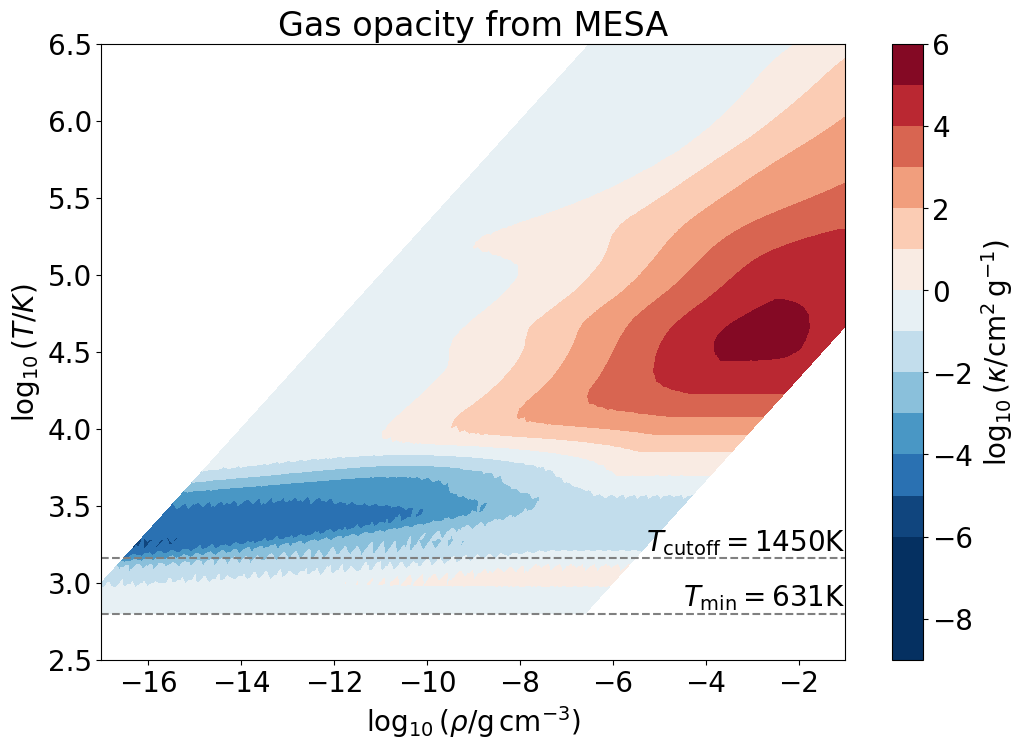

In [14]:
if __name__ == '__main__': #and do_debug:
    
    # reproducing Reichardt-2020-1 fig8

    do_mimic_Reichardt2020_fig8 = False
    
    fig, ax = plt.subplots(figsize=(12, 8))
    #fig.subplots_adjust(wspace=0.0)
    #ax0, ax1 = axes
    
    # x - R, y - T, z - kappa
    xx, yy = np.meshgrid(*eos_opacity._grid_noZX, indexing='ij')
    zz = eos_opacity._table_noZX
    # get log10_rho from log10_R
    # log10_R = np.log10(rho) + 18. - 3 * log10_T
    xx = xx - 18. + 3.* yy
    
    xi = xx.flatten()
    yi = yy.flatten()
    zi = zz.flatten()
    
    #ax1.scatter(xi, yi)
    #ax = ax0
    #ax.tricontour(xi, yi, zi)
    cntr = ax.tricontourf(
        xi, yi, zi, levels=13, cmap="RdBu_r",
        norm = mpl.colors.Normalize(vmin=-6, vmax=6, clip=True),
    )
    cbar = fig.colorbar(cntr, ax=ax)
    
    cbar.set_label("$\\log_{10}{(\\kappa / \\mathrm{cm}^2 \\, \\mathrm{g}^{-1})}$")
    ax.set_xlabel("$\\log_{10}{(\\rho / \\mathrm{g} \\, \\mathrm{cm}^{-3})}$")
    ax.set_ylabel("$\\log_{10}{(T / K)}$")
    
    if do_mimic_Reichardt2020_fig8:
        ax.set_xlim((-17, -1))
        ax.set_ylim((3, 7))
    else:
        ax.set_xlim((-17, -1))
        ax.set_ylim((2.5, 6.5))
        log10_Tmin = 2.8
        ax.axhline(log10_Tmin, color='grey', linestyle='dashed')
        ax.text(-1, log10_Tmin+0.05, f'$T_\\mathrm{{min}} = {10**log10_Tmin:.0f}$K', ha='right')
        log10_Tcut = np.log10(1450)
        ax.axhline(log10_Tcut, color='grey', linestyle='dashed')
        ax.text(-1, log10_Tcut+0.05, f'$T_\\mathrm{{cutoff}} = {10**log10_Tcut:.0f}$K', ha='right')



    outfilename_noext = f"{output_dir}kap-mesa-table"

    fig.savefig(f"{outfilename_noext}.pdf")
    
    ax.set_title("Gas opacity from MESA")
    fig.savefig(f"{outfilename_noext}.png")

    fig.show()
    print(f"{outfilename_noext = }")

In [15]:
_grid_noZX

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

KeyError: 'temp'

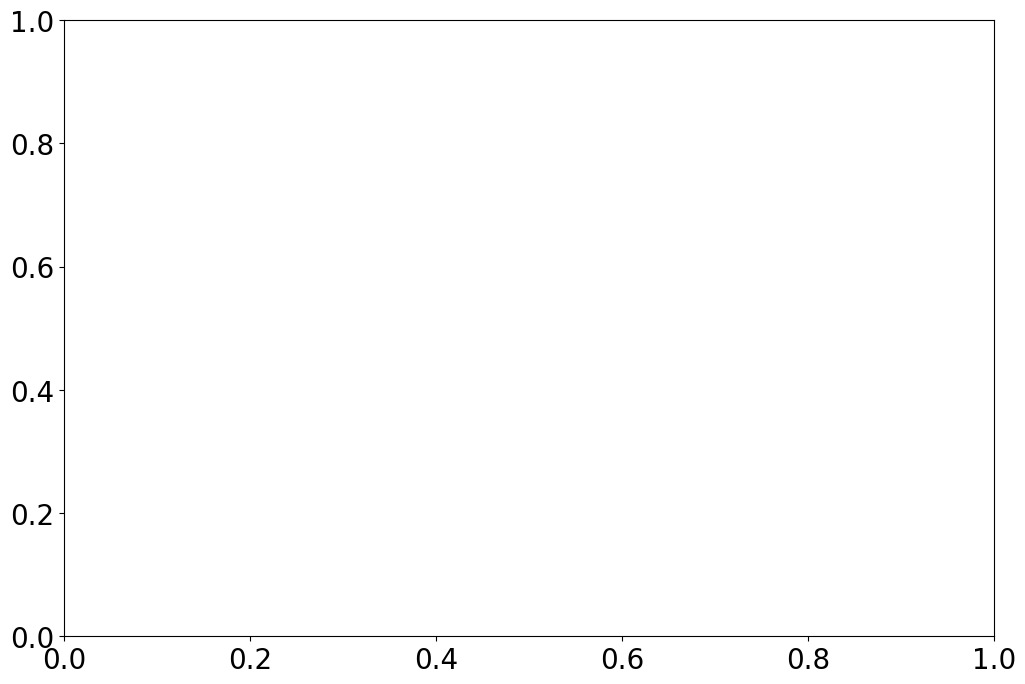

In [28]:
if __name__ == '__main__': #and do_debug:
    
    # reproducing Reichardt-2020-1 fig8

    do_mimic_Reichardt2020_fig8 = False
    eos = mupl.get_eos(ieos=10, params={'X':0.6, 'Z':0.02})
    eos_table = mupl.eos.mesa._EoS_MESA_table(params={'X':0.7, 'Z':0.02}, settings=mupl.DEFAULT_SETTINGS)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    #fig.subplots_adjust(wspace=0.0)
    #ax0, ax1 = axes
    
    # x - rho(V), y - u(E), z - kappa
    xx, yy = np.meshgrid(*eos_table._grid_noZX, indexing='ij')
    xx = 10**(xx+0.7*yy-20)
    yy = 10**yy
    zz = eos.get_val_cgs('temp', xx, yy) # eos._table_noZX
    
    xi = xx.flatten()
    yi = yy.flatten()
    zi = zz.flatten()
    
    #ax1.scatter(xi, yi)
    #ax = ax0
    #ax.tricontour(xi, yi, zi)
    # cntr = ax.tricontourf(
    #     xi, yi, zi, levels=13, cmap="RdBu_r",
    #     norm = mpl.colors.Normalize(vmin=-6, vmax=6, clip=True),
    # )
    cntr = ax.contour(xx, yy, zz)
    cbar = fig.colorbar(cntr, ax=ax)
    
    cbar.set_label("$\\log_{10}{(\\kappa / \\mathrm{cm}^2 \\, \\mathrm{g}^{-1})}$")
    ax.set_xlabel("$\\log_{10}{(\\rho / \\mathrm{g} \\, \\mathrm{cm}^{-3})}$")
    ax.set_ylabel("$\\log_{10}{(T / K)}$")
    
    if do_mimic_Reichardt2020_fig8:
        ax.set_xlim((-17, -1))
        ax.set_ylim((3, 7))
    else:
        ax.set_xlim((-17, -1))
        ax.set_ylim((2.5, 6.5))
        log10_Tmin = 2.8
        ax.axhline(log10_Tmin, color='grey', linestyle='dashed')
        ax.text(-1, log10_Tmin+0.05, f'$T_\\mathrm{{min}} = {10**log10_Tmin:.0f}$K', ha='right')
        log10_Tcut = np.log10(1450)
        ax.axhline(log10_Tcut, color='grey', linestyle='dashed')
        ax.text(-1, log10_Tcut+0.05, f'$T_\\mathrm{{cutoff}} = {10**log10_Tcut:.0f}$K', ha='right')



    outfilename_noext = f"{output_dir}kap-mesa-table"

    fig.savefig(f"{outfilename_noext}.pdf")
    
    ax.set_title("Gas opacity from MESA")
    fig.savefig(f"{outfilename_noext}.png")

    fig.show()
    print(f"{outfilename_noext = }")

In [33]:
eos_table._table_withZX

array([], dtype=float64)

In [34]:
np.count_nonzero(zz[1:-1, 1:-1])

13924

In [11]:
eos_opacity._log10_T_arr

array([2.8  , 2.825, 2.85 , 2.875, 2.9  , 2.925, 2.95 , 2.975, 3.   ,
       3.025, 3.05 , 3.075, 3.1  , 3.125, 3.15 , 3.175, 3.2  , 3.225,
       3.25 , 3.275, 3.3  , 3.325, 3.35 , 3.375, 3.4  , 3.425, 3.45 ,
       3.475, 3.5  , 3.525, 3.55 , 3.575, 3.6  , 3.625, 3.65 , 3.675,
       3.7  , 3.725, 3.75 , 3.775, 3.8  , 3.825, 3.85 , 3.875, 3.9  ,
       3.925, 3.95 , 3.975, 4.   , 4.025, 4.05 , 4.075, 4.1  , 4.125,
       4.15 , 4.175, 4.2  , 4.225, 4.25 , 4.275, 4.3  , 4.325, 4.35 ,
       4.375, 4.4  , 4.425, 4.45 , 4.475, 4.5  , 4.525, 4.55 , 4.575,
       4.6  , 4.625, 4.65 , 4.675, 4.7  , 4.725, 4.75 , 4.775, 4.8  ,
       4.825, 4.85 , 4.875, 4.9  , 4.925, 4.95 , 4.975, 5.   , 5.025,
       5.05 , 5.075, 5.1  , 5.125, 5.15 , 5.175, 5.2  , 5.225, 5.25 ,
       5.275, 5.3  , 5.325, 5.35 , 5.375, 5.4  , 5.425, 5.45 , 5.475,
       5.5  , 5.525, 5.55 , 5.575, 5.6  , 5.625, 5.65 , 5.675, 5.7  ,
       5.725, 5.75 , 5.775, 5.8  , 5.825, 5.85 , 5.875, 5.9  , 5.925,
       5.95 , 5.975,

In [15]:
10**9

1000000000

{'X': 0.691, 'Z': 0.021, 'mu': 2.381}


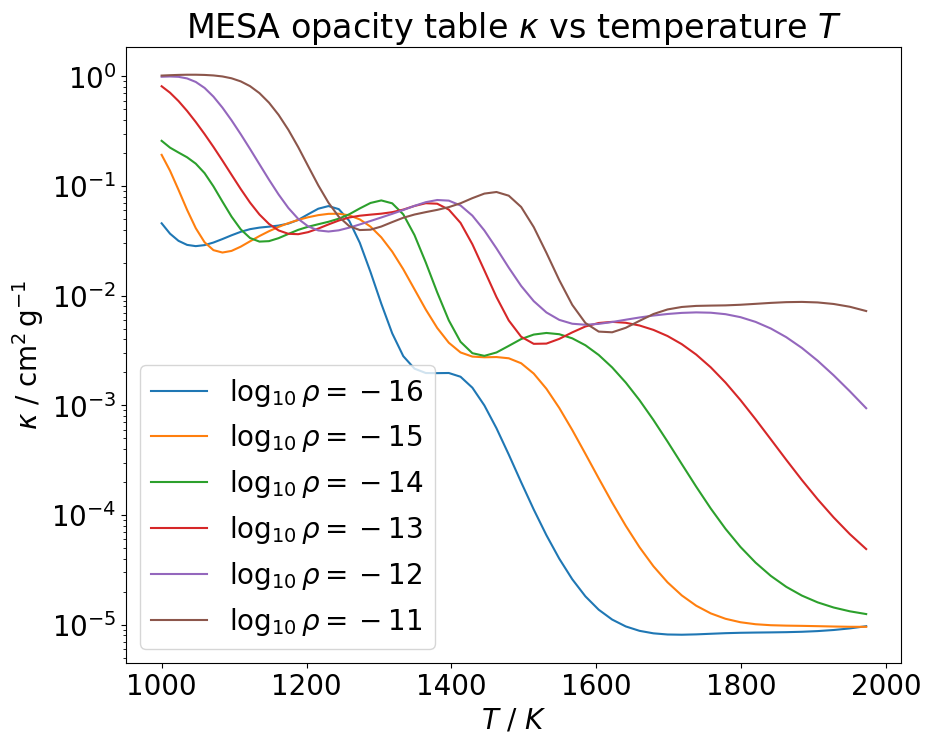

In [41]:
if __name__ == '__main__' and do_debug:
    params = JOB_PROFILES_DICT['2md']['params']
    #params = {'X': 0.7, 'Z': 0.02}  # the ones used in Ferguson-2005-1 fig9
    print(f"{params}")
    eos_opacity = EoS_MESA_opacity(params, settings)
    Ts = (10**np.arange(3., 3.3, 0.005))*units.K
    fig, ax = plt.subplots(figsize=(10, 8))
    for log10_rho in range(-16, -10, 1): #[-11.52]:
        # side note: log10_rho=-11.52 (i.e. log10_R=-3 when logT=3.16) is the one used in Ferguson-2005-1 fig9
        rho = (10**log10_rho)*(units.g/units.cm**3)
        kappas = eos_opacity.get_kappa(rho=rho, T=Ts, method='cubic') #, method='cubic'
        ax.semilogy(Ts.cgs, kappas.cgs, '-', label=f"$\\log_{{10}} \\rho = {log10_rho}$")

    ax.legend()
    ax.set_title("MESA opacity table $\\kappa$ vs temperature $T$")
    ax.set_ylabel(f"$\\kappa$ / {kappas.cgs.unit.to_string('latex_inline')}")
    ax.set_xlabel(f"$T$ / $K$")
    fig.savefig(f"{output_dir}kap-mesa_kappa-T-rho.png")

In [ ]:
# plotting kappa vs Temp and kappa vs rho
if __name__ == '__main__':

    ylim = (1e-6, 1e4)
    xlims= {
        'T'  : (  5.,  2e6),
        'rho': (2e-20, 1e-3),
    }
    
    #mpdf = mupl.MyPhantomDataFrames()
    for job_nickname in ['2md', '4md']:
        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        params      = job_profile['params']
        eos_opacity = EoS_MESA_opacity(params, settings)

        
        if NPROCESSES <= 1:

            # single process
            if __name__ == '__main__' and is_verbose(verbose, 'note'):
                say('note', "script_kappaProfile", verbose, f"Using single process.")
            
            outfilenames = []
            for file_index in job_profile['file_indexes']:
                outfilename = plot_kappaProfile(job_name, file_index, eos_opacity, xlims, ylim, verbose)
                outfilenames.append(outfilename)
        else:

            # multi-process
            if __name__ == '__main__' and is_verbose(verbose, 'note'):
                say('note', "script_kappaProfile", verbose, f"Using {NPROCESSES} processes.")
                
            args = [(job_name, file_index, eos_opacity, xlims, ylim, 0) for file_index in job_profile['file_indexes']]
            with Pool(processes=NPROCESSES) as pool:
                outfilenames = pool.starmap(plot_kappaProfile, args)


        # define job_folder_prefix
        for i in range(len(job_name)-1, -1, -1):
            if job_name[i] == path.sep:
                job_folder_prefix = job_name[:i]
                break
            else:
                job_folder_prefix = job_name
        with ImageSequenceClip(outfilenames, fps=fps) as vid:
            moviefilename = f"{job_folder_prefix}__kappaProfile__movie.mp4"
            vid.write_videofile(moviefilename)

    print("\n\n\n*** All Done. ***\n\n\n")

*   Note   :    MyPhantomDataFrames.read():
	Reading filename='../photosphere/luis_2md/light_00000'
*   Note: Reseting Origin to CoM...
    Note: CoM location is now: self.loc_CoM = array([ 0.00000000e+00,  3.59257537e-16, -1.80945419e-16])
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass")
	However in phantom kappa is often (?) assumed to be in cgs unit.
	
    If so, please COVERT KAPPA MANNUALLY into PHANTOM UNITS by using code, such as:
	
        mpdf.data['gas']['kappa'] = 
	mupl.set_as_quantity(mpdf.data['gas']['kappa'], units.cm**2/units.g).to_value(mpdf.units['opacity'])
*   Note   :    MyPhantomDataFrames.read():
	Reading filename='../photosphere/luis_2md/light_00100'
*   Note: Reseting Origin to CoM...
    Note: CoM location is now: self.loc_CoM = array([ 0.00000000e+00, -6.16342983e-15, -8.78770269e-16])
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We he

if __name__ == '__main__':
    
    plt.close(fig)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    x = mpdf.get_val('T').to(unitsOut['temp'], equivalencies=units.equivalencies.temperature())
    y = mpdf.get_val('rho').to(unitsOut['density'])
    ax.loglog(x, y, '.')
    ax.text(
        0.95, 0.5,
        f"Time = {mpdf.get_time(unitsOut['time']):.1f}",
        color = "black", ha = 'right', va = 'top',
        transform=ax.transAxes,
    )
    ax.set_xlim(xlims['T'])
    ax.set_ylim(xlims['rho'])



